
# Практическое задание 4. Бустинг и бэггинг

## Общая информация
Дата выдачи: 14.01.2024

Мягкий дедлайн: 28.01.2024 23:59 MSK

Жёсткий дедлайн: 04.02.2024 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. 

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-04-Username.ipynb

Username — ваша фамилия на латинице

## О задании

В этом задании вам предстоит вручную запрограммировать один из самых мощных алгоритмов машинного обучения — бустинг. Работать мы будем на двух наборах данных: многомерных данных по кредитам с kaggle и синтетических двумерных. В данных с kaggle целевая переменная показывает, вернуло ли кредит физическое лицо:

In [19]:
import numpy as np
import pandas as pd
import collections
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from scipy.special import logit
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier

In [3]:
#!wget  -O 'bank_data.csv' -q 'https://www.dropbox.com/s/uy27mctxo0gbuof/bank_data.csv?dl=0'

In [4]:
df = pd.read_csv('bank_data.csv')
df.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
5841,36,services,married,high.school,no,yes,yes,cellular,aug,thu,...,2,999,1,failure,-2.9,92.201,-31.4,0.873,5076.2,1
6900,28,student,single,high.school,no,yes,no,cellular,jul,mon,...,2,6,1,success,-1.7,94.215,-40.3,0.827,4991.6,1
8627,41,technician,single,university.degree,no,no,no,telephone,jun,tue,...,1,999,0,nonexistent,-2.9,92.963,-40.8,1.262,5076.2,1
5124,28,entrepreneur,married,basic.9y,unknown,yes,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,1
2637,41,management,married,unknown,unknown,no,yes,telephone,jun,thu,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.866,5228.1,1


Разделим на train и test (random_state не меняем)

In [5]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

Генерируем синтетические данные (seed не меняем)

In [31]:
np.random.seed(42)

num_obs = 10 ** 5
num_thresholds = 50

X_synthetic = np.random.normal(scale=3, size=[num_obs, 2])
x1_thresholds = np.random.choice(X_synthetic[:, 0], num_thresholds, False)
x2_thresholds = np.random.choice(X_synthetic[:, 1], num_thresholds, False)

gains = np.random.uniform(-0.4086, 0.5, size=[2 * num_thresholds, 1])
x1_thresholds_cond = [X_synthetic[:, 0] >= threshold for threshold in x1_thresholds]
x2_thresholds_cond = [X_synthetic[:, 1] >= threshold for threshold in x2_thresholds]

noise = np.random.uniform(-0.5, 0.5, size=num_obs)

y_synthetic_probits = np.sum(
    gains[:num_thresholds] * x1_thresholds_cond + gains[num_thresholds:] * x2_thresholds_cond, axis=0
) + noise
y_synthetic = np.sign(y_synthetic_probits)

X_train_synthetic, y_train_synthetic = X_synthetic[:int(num_obs * 0.8)], y_synthetic[:int(num_obs * 0.8)]
X_test_synthetic, y_test_synthetic = X_synthetic[int(num_obs * 0.8):], y_synthetic[int(num_obs * 0.8):]

px.histogram(x = y_synthetic_probits, nbins=100)

Некоторый полезный код для визуализации предсказаний (пригодится позже)

In [32]:
import matplotlib.pyplot as plt

def plot_predicts(model, features, targets, x_lim=[-15.0, 15.0], y_lim=[-15.0, 15.0],
                  examples_density=0.01, steps=1000, num_ticks=6, title='', mode='classification'):
    '''
    Функция для визуализации предсказаний модели на двухмерной плоскости
    param model: обученная модель классификации или регрессии для двухмерных объектов
    param features: признаки выборки (a.k.a. X)
    param targets: целевая переменная выборки (a.k.a y)
    param x_lim: пределы для x
    param y_lim: пределы для y
    param examples_density: доля выборки, которая будет нарисована
    param steps: частота разбиения плоскости
    param num_ticks: число подписей на графике
    param title: заголовок графика
    param mode: режим 'classification' - вероятности положительного класса
                режим 'regression' - вещественная целевая переменная
    '''
    
    mask = np.random.choice([True, False], size=features.shape[0], 
                            p=[examples_density, 1.0 - examples_density])
    features_x = (features[mask, 0] - x_lim[0]) / (x_lim[1] - x_lim[0]) * steps
    features_y = (features[mask, 1] - y_lim[0]) / (y_lim[1] - y_lim[0]) * steps
    
    xs = np.linspace(x_lim[0], x_lim[1], steps)
    ys = np.linspace(y_lim[0], y_lim[1], steps)
    
    xs, ys = np.meshgrid(xs, ys)
    grid = np.stack([xs.flatten(), ys.flatten()], axis=1)
    if mode == 'classification':
        predicts = model.predict_proba(grid)[:, 1].reshape(steps, steps)
        values = (targets[mask] == 1).astype(float)
    elif mode == 'regression':
        predicts = model.predict(grid).reshape(steps, steps)
        values = targets[mask]
    else:
        raise ValueError('Unknown mode')
    
    plt.figure(figsize=(10, 10))
    plt.imshow(predicts, origin='lower')
    plt.scatter(features_x, features_y, c=values, edgecolors='white', linewidths=1.5)
    plt.colorbar()
    
    plt.xticks(np.linspace(0, steps, num_ticks), np.linspace(x_lim[0], x_lim[1], num_ticks))
    plt.yticks(np.linspace(0, steps, num_ticks), np.linspace(y_lim[0], y_lim[1], num_ticks))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.grid()
    plt.show()

#### 1. (4 балла) Реализуйте бустинг для задачи бинарной классификации.

Поскольку градиентный бустинг обучается через последовательное создание моделей, может получиться так, что оптимальная с точки зрения генерализации модель будет получена на промежуточной итерации. Обычно для контроля такого поведения в методе `fit` передается также валидационная выборка, по которой можно оценивать общее качество модели в процессе обучения (желательно делать это каждую итерацию, но если ваша имплементация слишком медленная или ваше железо не тянет, можно делать это реже). Кроме того, нет смысла обучать действительно глубокую модель на 1000 деревьев и больше, если оптимальный ансамбль получился, к примеру, на 70 итерации и в течение какого-то количества итераций не улучшился - поэтому мы также задействуем early stopping при отсутствии улучшений в течение некоторого числа итераций.

In [33]:
class Boosting:

    def __init__(
            self,
            base_model_class=DecisionTreeRegressor,
            base_model_params: dict = {'max_features': 0.1},
            n_estimators: int = 10,
            learning_rate: float = 0.1,
            subsample: float = 0.3,
            random_seed: int = 228,
            custom_loss: list or tuple = None,
            use_best_model: bool = False,
            n_iter_prestop: int = None
    ):

        # Класс базовой модели
        self.base_model_class = base_model_class
        # Параметры для инициализации базовой модели
        self.base_model_params = base_model_params
        # Число базовых моделей
        self.n_estimators = n_estimators
        # Длина шага (которая в лекциях обозначалась через eta)
        self.learning_rate = learning_rate
        # Доля объектов, на которых обучается каждая базовая модель
        self.subsample = subsample
        # seed для бутстрапа, если хотим воспроизводимость модели
        self.random_seed = random_seed
        # Использовать ли при вызове predict и predict_proba лучшее
        # с точки зрения валидационной выборки число деревьев в композиции
        self.use_best_model = use_best_model
        # число итераций, после которых при отсутствии улучшений на валидационной выборке обучение завершается
        self.n_iter_prestop = n_iter_prestop

        # Лучшее количество базовых моделей
        self.best_n = self.n_estimators - 1

        # Плейсхолдер для нулевой модели
        self.initial_model_pred = None
        self.initial_pred = None

        # Список для хранения весов при моделях
        self.gammas = [None] * self.n_estimators

        # Создаем список базовых моделей
        self.models = [self.base_model_class(**self.base_model_params) for _ in range(self.n_estimators)]

        # Сумма предыдущих предсказаний (т.е. композиция на N-1 шаге)
        self.old_pred = self.initial_model_pred

        # Если используем свою функцию потерь, ее нужно передать как список из loss-a и его производной
        if custom_loss is not None:
            self.loss_fn, self.loss_derivative = custom_loss
        else:
            self.sigmoid = lambda z: 1 / (1 + np.exp(-z))
            self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
            self.loss_derivative = lambda y, z: -y * self.sigmoid(-y * z)

    def _fit_new_model(self, X: np.ndarray, y: np.ndarray or list, n_model: int):
        """
        Функция для обучения одной базовой модели бустинга
        :param X: матрица признаков
        :param y: вектор целевой переменной
        :param n_model: номер модели, которую хотим обучить
        """
        leftovers = -self.loss_derivative(y, self.old_pred)
        self.models[n_model].fit(X, leftovers)
        upd_preds = self.models[n_model].predict(X)
        self.gammas[n_model] = self._find_optimal_gamma(y, self.old_pred, upd_preds)
        self.old_pred = self.old_pred + self.learning_rate * self.gammas[n_model] * upd_preds

    def _fit_initial_model(self, X, y):
        """
        Функция для построения нулевой (простой) модели. Не забудьте взять логарифм, потому что сигмоида применяется
        уже к сумме предсказаний базовых моделей, а не к каждому предсказанию каждой модели по отдельности.
        Подойдёт константная модель, возвращающая самый популярный класс,
        но если хотите, можете сделать что-нибудь посложнее.
        """
        # self.initial_pred = np.log(stats.mode(y)[0][0])
        # self.initial_pred = stats.mode(y)[0][0]
        self.initial_pred = logit((y == 1).sum() / len(y))
        self.initial_model_pred = np.full(len(y), self.initial_pred)
        self.old_pred = self.initial_model_pred

    def _find_optimal_gamma(self, y: np.ndarray or list, old_predictions: np.ndarray,
                            new_predictions: np.ndarray, boundaries: tuple or list = (0.01, 1)):
        """
        Функция для поиска оптимального значения параметра gamma (коэффициент перед новой базовой моделью).
        :param y: вектор целевой переменной
        :param old_predictions: вектор суммы предсказаний предыдущих моделей (до сигмоиды)
        :param new_predictions: вектор суммы предсказаний новой модели (до сигмоиды)
        :param boudnaries: в каком диапазоне искать оптимальное значение ɣ (array-like объект из левой и правой границ)
        """
        # Определеяем начальные лосс и оптимальную гамму
        loss, opt_gamma = self.loss_fn(y, old_predictions), 0
        # Множество, на котором будем искать оптимальное значение гаммы
        gammas = np.linspace(*boundaries, 100)
        # Простым перебором ищем оптимальное значение
        for gamma in gammas:
            predictions = old_predictions + gamma * new_predictions
            gamma_loss = self.loss_fn(y, predictions)
            if gamma_loss < loss:
                opt_gamma = gamma
                loss = gamma_loss

        return opt_gamma

    def fit(self, X, y, eval_set=None):
        """
        Функция для обучения всей модели бустинга
        :param X: матрица признаков
        :param y: вектор целевой переменной
        :eval_set: кортеж (X_val, y_val) для контроля процесса обучения или None, если контроль не используется
        """
        X, _, y, _ = train_test_split(X, y, train_size=self.subsample, random_state=self.random_seed)
        self._fit_initial_model(X, y)
        if eval_set is not None:
            X_val, y_val = eval_set
            best_loss = self.loss_fn(y_val, self.initial_model_pred)
            prestop_cnt = 0
        for n_model in range(self.n_estimators):
            self._fit_new_model(X, y, n_model)

            # evaluation
            if eval_set is not None:
                val_pred = self.models[n_model].predict(X_val)
                curr_loss = self.loss_fn(y_val, val_pred)
                if curr_loss < best_loss:
                    prestop_cnt = 0
                    best_loss = curr_loss
                    self.best_n = n_model
                else:
                    prestop_cnt += 1
                    if prestop_cnt == self.n_iter_prestop:
                        break

    def predict(self, X: np.ndarray):
        """
        Функция для предсказания классов обученной моделью бустинга
        :param X: матрица признаков
        """
        preds = np.full(X.shape[0], self.initial_pred, dtype=float)
        iterations = self.best_n if self.use_best_model else self.n_estimators
        for n_model in range(iterations):
            preds += self.gammas[n_model] * self.models[n_model].predict(X)
        return preds

    def predict_proba(self, X: np.ndarray):
        """
        Функция для предсказания вероятностей классов обученной моделью бустинга
        :param X: матрица признаков
        """
        pos_prob = self.sigmoid(self.predict(X))
        neg_prob = 1 - pos_prob
        
        return np.column_stack((neg_prob, pos_prob))

    @property
    def feature_importances_(self):
        """
        Для бонусного задания номер 5.
        Функция для вычисления важностей признаков.
        Вычисление должно проводиться после обучения модели
        и быть доступно атрибутом класса.
        """
        # Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:


#### Тест для вашей имплементации. Если класс написан правильно, две следующие ячейки должна отработать без ошибок и относительно быстро (у автора задания 2 и 0.2 секунд соответственно, accuracy 0.911 и 0.879 соответственно). Если у вас получилось качество выше указанного — отлично!

In [21]:
%%time

boosting = Boosting()
boosting.fit(X_train_synthetic, y_train_synthetic)
# Без разницы, выдает эта строка классы или вероятности
preds = np.round(boosting.predict(X_test_synthetic) > 0.5)
print(accuracy_score((y_test_synthetic == 1), np.round(preds)))
assert accuracy_score((y_test_synthetic == 1), np.round(preds)) > 0.9

0.9005
CPU times: user 493 ms, sys: 0 ns, total: 493 ms
Wall time: 492 ms


In [24]:
%%time

boosting = Boosting()
boosting.fit(df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values, df_train.y.values)
# Без разницы, выдает эта строка классы или вероятности
preds = np.round(boosting.predict(df_test.select_dtypes(['int64', 'float64']).drop(columns='y').values) > 0.5)
assert accuracy_score((df_test.y.values == 1), np.round(preds)) > 0.87

CPU times: user 72.3 ms, sys: 0 ns, total: 72.3 ms
Wall time: 72.9 ms


#### 2. (2 балла) Сравните результаты вашей имплементации бустинга с указанными ниже базовыми моделями на обоих датасетах и ответьте на вопросы. Разумеется, надо измерять качество на тестовых данных. 

Варианты для базовой модели (разумеется, не надо их программировать самостоятельно, берите нужные классы из sklearn):

- Решающее дерево глубины 6
- Случайный лес (число деревьев — на ваше усмотрение, только не слишком мало)
- Линейная регрессия

Вопросы:

1) Какая из моделей имеет оптимальное качество? С чем это связано?

2) Какая из моделей сильнее переобучается? Есть ли преимущества от использования ранней остановки и обрезания бустинга до лучшей модели?

3) Работает ли бустинг над линейными регрессиями лучше, чем одна логистическая регрессия? Как объяснить этот результат?

4) Визуализируйте предсказания моделей на синтетическом датасете (для этого можете воспользоваться вспомогательной функцией plot_predicts). Чем отличаются картинки, которые получаются у разных алгоритмов? Сделайте выводы.

Ответы:
1) На банковском датасете, наилучшее качество бустинг c базовой моделью случайного леса,  на синт. реш дерева глубины 6 небольшое смещение а бустинг его еще уменьшает  
2) переобучается сильнее бустинг на случ лесе. раняя остановка не помогает так как немного итераций

3) Одна логистическая регрессия лучше, потому что по сути бустинг линейных регрессий - это линейная комбинация линейных регрессий

4) У более качественных моделей цвета точек чаще совпадают с цветом фона. В целом, если модель уверена в предсказании и вероятность соответствующая (большая для положительных объектов, маленькая для отрицательных), то цвет либо желтый, либо фиолетовый. А если вероятность небольшая, то цвет бирюзовый - так выражается неопределенность

real data accuracy: 0.8717672413793104
Synthetic accuracy: 0.9108


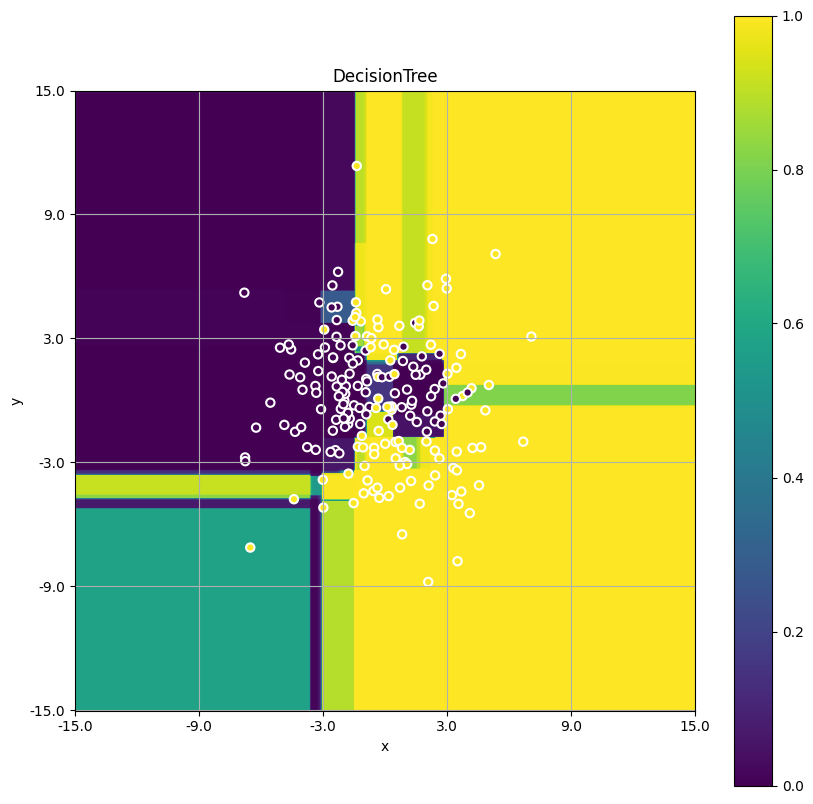

In [36]:
model_dt = Boosting(base_model_class=DecisionTreeRegressor,base_model_params = {'max_depth':6})

model_dt.fit(df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values, df_train.y.values)
preds = np.round(model_dt.predict(df_test.select_dtypes(['int64', 'float64']).drop(columns='y').values) > 0.5)
print('Real data accuracy:',accuracy_score((df_test.y.values == 1), np.round(preds) > 0.87))

model_dt.fit(X_train_synthetic, y_train_synthetic)
preds = model_dt.predict(X_test_synthetic)
print('Synthetic accuracy:',accuracy_score((y_test_synthetic == 1), np.round(preds) > 0.9))

plot_predicts(model_dt, X_test_synthetic, y_test_synthetic, title='DecisionTree' )

df accuracy: 0.8863146551724138
Synthetic accuracy: 0.90715


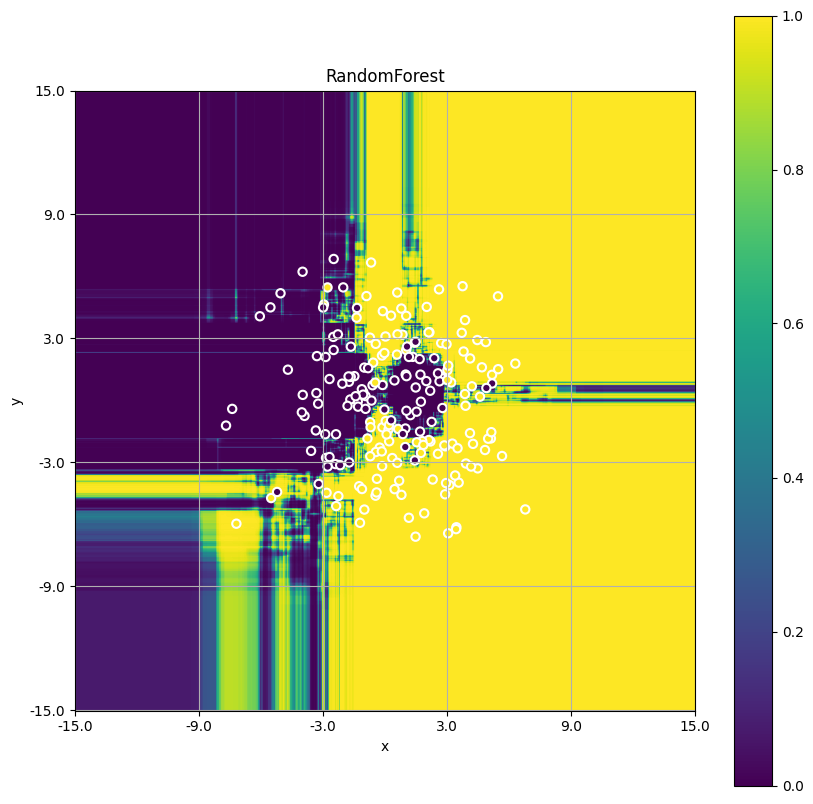

In [37]:
model_rf = Boosting(base_model_class = RandomForestRegressor, base_model_params = {'n_estimators':20})

model_rf.fit(df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values, df_train.y.values)
preds = np.round(model_rf.predict(df_test.select_dtypes(['int64', 'float64']).drop(columns='y').values) > 0.5)
print('Real data accuracy:',accuracy_score((df_test.y.values == 1), np.round(preds) > 0.87))

model_rf.fit(X_train_synthetic, y_train_synthetic)
preds = model_rf.predict(X_test_synthetic)
print('Synthetic accuracy:',accuracy_score((y_test_synthetic == 1), np.round(preds) > 0.9))

plot_predicts(model_rf, X_test_synthetic, y_test_synthetic,title = 'RandomForest' )

df accuracy: 0.8168103448275862
Synthetic accuracy: 0.67035


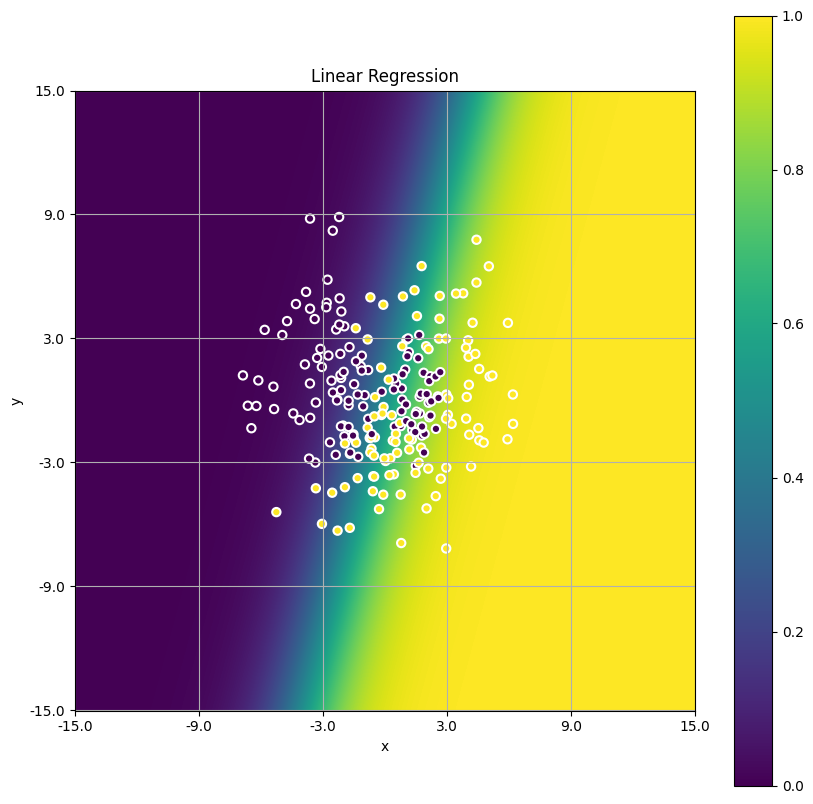

In [38]:
from sklearn.linear_model import LinearRegression
model_lr = Boosting(LinearRegression, {})

model_lr.fit(df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values, df_train.y.values)
preds = np.round(model_lr.predict(df_test.select_dtypes(['int64', 'float64']).drop(columns='y').values) > 0.5)
print('Real data accuracy:',accuracy_score((df_test.y.values == 1), np.round(preds) > 0.87))

model_lr.fit(X_train_synthetic, y_train_synthetic)
preds = model_lr.predict(X_test_synthetic)
print('Synthetic accuracy:',accuracy_score((y_test_synthetic == 1), np.round(preds) > 0.9))

plot_predicts(model_lr, X_test_synthetic, y_test_synthetic, title = 'Linear Regression')

In [41]:
from sklearn.linear_model import LogisticRegression
model_logr = LogisticRegression()

model_logr.fit(df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values, df_train.y.values)
preds = np.round(model_logr.predict(df_test.select_dtypes(['int64', 'float64']).drop(columns='y').values) > 0.5)
print('Real data accuracy:',accuracy_score((df_test.y.values == 1), np.round(preds) > 0.87))

model_logr.fit(X_train_synthetic, y_train_synthetic)
preds = model_logr.predict(X_test_synthetic)
print('logreg Synthetic accuracy:',accuracy_score((y_test_synthetic == 1), np.round(preds) > 0.9))

logreg df accuracy: 0.8485991379310345
logreg Synthetic accuracy: 0.68905


/home/choosen-one/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



#### 3. (2 балла) Мы разобрались с бустингом, теперь интересно посмотреть на совсем дикие комбинации моделей. Сравните результаты следующих моделей на обоих датасетах и ответьте на вопросы. Разумеется, надо измерять качество на тестовых данных.

Используйте логистическую регрессию, случайный лес и BaggingClassifier из sklearn.

- Случайный лес
- Бэггинг на деревьях (поставьте для базовых деревьев min_samples_leaf=1)
- Бэггинг на деревьях с обучением каждого дерева на подмножестве признаков (`max_features` около 0.6 в BaggingClassifier)
- Бэггинг, у которого базовой моделью является бустинг с большим числом деревьев (> 100)
- Бэггинг на логистических регрессиях

1) Какая из моделей имеет лучшее качество? С чем это связано?

2) Какая из моделей сильнее всего переобучается? Помогает ли бустингу ранняя остановка? 

3) Исправляет ли бэггинг переобученность бустинга с большим числом деревьев?

4) Что лучше: случайный лес или бэггинг на деревьях с сэмплированием признаков?

5) Если использовать деревья в качестве базового алгоритма, что лучше — бэггинг или бустинг? С чем это связано?

Ответ:

1)  На синтетическом датасете лучше всего себя проявил бэггинг на бустинге из 100 деревьев (Bagging over Boosting выше). Такие результаты объясняются тем, что бустинг понижает смещение, а бэггинг разброс. На банковском датасете наилучшее качество у бустинга на деревьях (Boosting over Trees выше). Вернее, у RandomForest такое же значение test_accuracy, но бустинг не переобучился в отличие от леса.

2) Больше переобучается RandomForest, мы никак не ограничиваем сложность модели такими параметрами как max_depth или min_samples_leaf. В бустинге ранняя остановка немногает помогает снизить переобучение

3) Бустинг с большим числом дереьвев практически не переобучился, поэтому бэггинг поверх него не сильно меняет картину

4) Случайный лес лучше, чем бэггинг на деревьях с сэмплированием признаков, потому что в бэггинге у нас из-за ограничения на max_features модели получаются более похожими друг на друга и бэггинг не понижает разброс так хорошо как должен, и при этом смещение выше из-за сэмплирования, потому что мало данных для построения хороших моделей

5) Если использовать деревья в качестве базового алгоритма, то лучше использовать бустинг. Он понижает смещение и поэтому мы получаем лучше значение accuracy

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier

logbag = BaggingClassifier(LogisticRegression(max_iter=3000, C=0.3))
rf = RandomForestClassifier()
boosttree = GradientBoostingClassifier()
bagtree = BaggingClassifier(DecisionTreeClassifier())
subbagtree = BaggingClassifier(DecisionTreeClassifier(), max_features=0.6)
boobag = BaggingClassifier(GradientBoostingClassifier())
earlyboobag = BaggingClassifier(GradientBoostingClassifier(n_iter_no_change=10))

for model, name in [(rf, 'RandomForest'), (bagtree, 'Bagging over Trees'), (boosttree, 'Boosting over Trees'),
                    (subbagtree, 'Bagging over Trees with max_features=0.6'),
                    (boobag, 'Bagging over Boosting'), (earlyboobag, 'Bagging over Boosting with early stop'),
                    (logbag, 'Bagging over LogisticRegression')]:
    print(name)

    print('\nBankData')
    model.fit(df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values, df_train.y.values)
    test_preds = np.round(model.predict(df_test.select_dtypes(['int64', 'float64']).drop(columns='y').values) > 0.5)
    print('Test accuracy: ', round(accuracy_score((df_test.y.values == 1), np.round(test_preds)), 4))

    print('\nSyntheticData')
    model.fit(X_train_synthetic, y_train_synthetic)
    test_preds = np.round(model.predict(X_test_synthetic) > 0.5)
    print('Test accuracy: ', round(accuracy_score((y_test_synthetic == 1), np.round(test_preds)), 4),'\n')


RandomForest

BankData
Test accuracy:  0.8939

SyntheticData
Test accuracy:  0.9125 

Bagging over Trees

BankData
Test accuracy:  0.8761

SyntheticData
Test accuracy:  0.9054 

Boosting over Trees

BankData
Test accuracy:  0.8939

SyntheticData
Test accuracy:  0.9199 

Bagging over Trees with max_features=0.6

BankData
Test accuracy:  0.8793

SyntheticData
Test accuracy:  0.6797 

Bagging over Boosting

BankData
Test accuracy:  0.8901

SyntheticData
Test accuracy:  0.9211 

Bagging over Boosting with early stop

BankData
Test accuracy:  0.889

SyntheticData
Test accuracy:  0.9205 

Bagging over LogisticRegression

BankData
Test accuracy:  0.8534

SyntheticData
Test accuracy:  0.6889 



#### 4. (2 балла) Сравните на этих данных любую из трёх популярных имплементаций градиентного бустинга (xgboost, lightgbm, catboost) с вашей реализацией. Подберите основные гиперпараметры (число деревьев, длина шага, глубина дерева/число листьев) для обоих методов. Получилось ли у вас победить библиотечные реализации на тестовых данных? 

In [12]:
# Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*: